
### **Chapter 3: Optimization Fundamentals**


In this chapter, we introduce optimization problems under both unconstrained and constrained settings. We begin with unconstrained optimization, presenting several commonly used solving methods, accompanied by solver implementations in code. These methods will be tested across a variety of examples to illustrate their respective performance characteristics. Subsequently, we extend the discussion to constrained optimization problems. Utilizing CasADi’s symbolic framework, we store symbolic expressions and leverage its built-in solvers (e.g., qpOASES) to solve the problems and visualize the results. The theoretical foundations and implementation techniques introduced in this chapter will serve as the basis for subsequent chapters, such as those focusing on Model Predictive Control (MPC).

All the contents are summarized in the table below.  

<table border="1" style="border-collapse: collapse; text-align: center;">
  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 3 Exercise</th>
  </tr>

  <!-- Row group 1 -->
  <tr>
    <td rowspan="5">Unconstrained Optimization</td>
    <td>Example 1.1: implement the solver for unconstrained optimization problems</td>
  </tr>
  <tr>
    <td>Example 1.2: use Gradient-descent method to optimize Quadratic objective function</td>
  </tr>
  <tr>
    <td>Example 1.3: use Gradient-descent method to optimize Rosenbrock objective function</td>
  </tr>
  <tr>
    <td>Example 1.4: use Newton method to optimize Rosenbrock objective function</td>
  </tr>
  <tr>
    <td>Example 1.5: use Newton method to optimize Rastrigin objective function</td>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="4">Constrained Optimization</td>
    <td>Example 2.1: configurate the solver for QP problems</td>
  </tr>
  <tr>
    <td>Example 2.2: use QP solver to optimize quadratic objective function with linear constraint</td>
  </tr>
  <tr>
    <td>Example 3.1: configurate the solver for NLP problems</td>
  </tr>
  <tr>
    <td>Example 3.2: use SQP solver to optimize quadratic objective function with nonlinear constraint</td>
  </tr>

</table>

First, we need to import relevant packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import casadi as ca

<br>

### **Problem Definition:**

A generic optimization problem has the following form:

$$
\begin{aligned}
\min_{x} \quad & f(x) \\\\
\text{subject to} \quad & h_i(x) = 0, \quad \forall i \in \{1, 2, \dots, N\}, \\\\
& g_j(x) \leq 0, \quad \forall j \in \{1, 2, \dots, M\},
\end{aligned}
$$

where $ x \in \mathbb{R}^n $ is the **optimization variable** of the problem, $ f : \mathbb{R}^n \mapsto \mathbb{R} $ is the **objective function**, and $ h_i : \mathbb{R}^n \mapsto \mathbb{R} $ and $ g_j : \mathbb{R}^n \mapsto \mathbb{R} $ are the *equality* and **inequality constraint functions**, respectively. The objective function and the constraint functions can be general nonlinear functions. In this chapter, we generally assume that $ f $, $ h_i $, and $ g_j $ are differentiable functions.

##### **Subclasses of optimization problems:**

   1\) **Unconstrained Optimization:**  A general optimization problem without any constraints is called an unconstrained optimization problem. In this case, the goal is to find a minimizer of the objective function without being restricted by any equality or inequality conditions.

   2\) **Linear Programming (LP):** An optimization problem is called a linear program if both the objective function and all the constraint functions are linear. Specifically, the objective is a linear function of the decision variables, and the feasible set is defined by linear equality and inequality constraints.

   3\) **Quadratic Programming (QP):** An optimization problem is called a quadratic program if the objective function is quadratic and the constraints are linear. That is, the objective function includes a quadratic term, while the equality and inequality constraints are affine functions of the decision variables.

   4\) **Nonlinear Programming (NLP):** A general optimization problem with at least one nonlinear function, either in the objective function, the inequality constraints, or the equality constraints, is called a nonlinear program. In a nonlinear program, the functions involved can be nonlinear, and solving such problems typically requires iterative numerical methods.

<br>

----


### **Part (a): unconstrained optimization**

As discussed above, unconstrained optimization primarily follows the form:

$$
\begin{aligned}
\min_{x} \quad & f(x) 
\end{aligned}
$$

where the objective function is typically selected from several standard forms. In the exercises of this chapter, we primarily use the following three objective functions as test cases:

1) **Quadratic Function:** A simple convex function used as a basic test case for optimization algorithms.

$$
f(x) = (\frac{x_0}{2})^2 + x_1^2, \quad x^* = [0, 0]
$$

2) **Rosenbrock Function:** A non-convex function used to test the performance of optimization algorithms, characterized by a narrow, curved valley leading to the global minimum.

$$
f(x) = (1 - x_0)^2 + 100 (x_1 - x_0^2)^2, \quad x^* = [1, 0]
$$

3) **Rastrigin Function:** A highly multimodal function used to test the ability of algorithms to escape local minima, combining a quadratic term with a cosine modulation.

$$
f(x) = 20 + \left( x_0^2 - 10 \cos(2\pi x_0) \right) + \left( x_1^2 - 10 \cos(2\pi x_1) \right), \quad x^* = [0, 0]
$$


## ❓plots


#### **Algorithms for Unconstrained Optimization:**

The process of finding the optimal solution to an unconstrained optimization problem can generally be divided into two main steps: 
 - Step 1: determining the search direction to perform one step of update, with common methods including gradient descent and Newton's method;
 - Step 2: performing a line search along the chosen direction to find an appropriate step size, where backtracking is one of the simplest and most widely used strategies.  

In the following, we will briefly introduce these algorithms.

##### **Gradient descent**

Gradient descent (GD) is a first-order iterative optimization algorithm for finding the local minimum of a differentiable function.
At each iteration, it updates the current estimate by moving in the direction of the steepest descent, which is the negative gradient of the function at that point.

The update rule is given by:

$$
x_{k+1} = x_k - \alpha_k \nabla f(x_k)
$$

where:
   - $x_k$ is the current iterate,
   - $\nabla f(x_k)$ is the gradient of the objective function at $x_k$,
   - $\alpha_k > 0$ is the step size (or learning rate), which can be determined via a line search strategy.

Gradient Descent guarantees convergence to a local minimum for convex functions under appropriate conditions on the step size. However, it's also highly sensitive to the choice of step size—too small leads to slow convergence, while too large may cause divergence—and its inefficiency on ill-conditioned problems, where the optimization path can become highly zigzagged and slow.


##### **Newton method**

Newton's Method is a second-order optimization algorithm that uses both the gradient and the Hessian (second derivative) of the objective function to find a local minimum.
At each iteration, it updates the current estimate by moving along the Newton direction, which accounts for the local curvature of the function.

The update rule is given by:

$$
x_{k+1} = x_k - \alpha_k \left[\nabla^2 f(x_k)\right]^{-1} \nabla f(x_k)
$$

where $\nabla^2 f(x_k)$ is the Hessian matrix of the objective function at $x_k$.


When the Hessian is positive definite and the initial guess is sufficiently close to the minimizer, Newton's Method achieves quadratic convergence, making it significantly faster than first-order methods like gradient descent near the solution.



##### **Line search (backtracking)**

Line search is a subroutine in optimization algorithms that determines an appropriate step size along a given search direction. The goal is to ensure sufficient decrease in the objective function while avoiding overly small steps. One of the most common and simple methods is **Backtracking Line Search**. It starts with a relatively large initial step size and repeatedly reduces it until a sufficient decrease condition (typically the **Armijo condition**) is satisfied. The pseudocode of the algorithm is shown below:

 - Start with an initial step size $\alpha = \alpha_0$ (typically $\alpha_0 = 1$).
 - Check whether the **Armijo condition** holds: $f(x_k + \alpha p_k) \leq f(x_k) + c \alpha \nabla f(x_k)^T p_k$, where $c \in (0,1)$ is a small constant (e.g., $10^{-4}$).
 - If the condition is not satisfied, shrink the step size by a factor $\beta \in (0,1)$ (e.g., $\beta = 0.5$), that is, update $\alpha \leftarrow \beta \alpha$, and repeat the check.
 - Continue until the Armijo condition is satisfied.


<br>


#### **Example 1.1: implement the solver for unconstrained optimization problems**  

Based on the three algorithms introduced above, we now implement a solver for unconstrained optimization problems, which uses GD or Newton's method as the direction search algorithm, and applies the backtracking of the line search algorithm to determine a suitable step size. The implementation of the solver will follow the steps below:

&nbsp;&nbsp;&nbsp;&nbsp;1\) Initialize the algorithm parameters, including the starting point of the iteration $x_0$ and the line search parameters such as $\alpha_0$, $\beta$, and $c$;

&nbsp;&nbsp;&nbsp;&nbsp;2\) Use the CasADi symbolic system to define the symbolic variable $x$, and construct the expressions for the objective functions: Quadratic, Rosenbrock, and Rastrigin;

&nbsp;&nbsp;&nbsp;&nbsp;3\) Use automatic differentiation (Autodiff) to compute the Jacobian and Hessian of the objective function;

&nbsp;&nbsp;&nbsp;&nbsp;4\) Implement the main iteration loop:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; i\) Based on the precomputed Jacobian and Hessian information, determine the search direction using either Gradient Descent or Newton’s method;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ii\) Use backtracking line search starting from $\alpha_0$, progressively reducing the step size to find the largest 
$\alpha$ that satisfies the Armijo condition;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; iii\) Perform one iteration based on the search direction and step size, and check whether the convergence criterion is satisfied.

*Note that: for the symbolic framework, please check out this material https://web.casadi.org/docs/#document-symbolic*. *Section 3.3 shows how to define the symbolic variables.*  *Section 3.9 shows how to use the automatic differentiation to solve the Jacobian and Hessian.*  



In [2]:
class UnconstrOptimizer:
    def __init__(self, alpha_0 = 1.0, beta = 0.5, c = 1e-4):

        self.func_flag = 'quadratic'

        self.x_init = np.array([0.0, 0.0])

        self.solution_trajectory = []
        self.directions = []

        self.x = ca.MX.sym('x', 2)
        
        # Hyperparameters for line search
        self.alpha_0 = alpha_0
        self.beta = beta
        self.c = c

    def set_objective(self, func_type='quadratic'):
        self.func_flag = func_type

        if func_type == 'quadratic':
            expr = 1/2*(self.x[0]**2/4 + self.x[1]**2)
            self.global_minima = np.array([0.0, 0.0])

        elif func_type == 'rosenbrock':
            expr = (1 - self.x[0])**2 + 100*(self.x[1] - self.x[0]**2)**2
            self.global_minima = np.array([1.0, 1.0])

        elif func_type == 'rastrigin':
            expr = 20 + (self.x[0]**2 - 10*ca.cos(2*np.pi*self.x[0])) + (self.x[1]**2 - 10*ca.cos(2*np.pi*self.x[1]))
            self.global_minima = np.array([0.0, 0.0])

        else:
            raise ValueError("Unknown function type.")

        self.expr = expr
        self.f = ca.Function('f', [self.x], [expr])
        self.grad_f = ca.Function('grad_f', [self.x], [ca.gradient(expr, self.x)])
        self.hess_f = ca.Function('hess_f', [self.x], [ca.hessian(expr, self.x)[0]])

    def solve(self, x_init, method='gd', max_step=100, tol=1e-6):

        self.x_init = np.array(x_init, dtype=np.float64)
        self.method = method
        self.tol = tol
        self.max_step = max_step

        self.solution_trajectory = [self.x_init.copy()]
        self.directions = []

        x_val = np.copy(self.x_init)

        for _ in range(self.max_step):
            grad = self.grad_f(x_val).full().flatten()
            hess = self.hess_f(x_val).full()

            # Search direction
            if self.method == 'gd':
                direction = -grad
            elif self.method == 'newton':
                direction = -np.linalg.solve(hess + 1e-8*np.eye(2), grad)
            else:
                raise ValueError("Method must be 'gd' or 'newton'")

            descent = grad @ direction
            if abs(descent) < self.tol:
                break

            # Line search (backtracking)
            alpha = self.alpha_0
            f0 = float(self.f(x_val))
            while float(self.f(x_val + alpha * direction)) > f0 + self.c * alpha * descent:
                alpha *= self.beta
            
            # Update
            x_val = x_val + alpha * direction
            self.solution_trajectory.append(x_val.copy())
            self.directions.append(direction.copy())

    def plot_results(self):
        sol = np.array(self.solution_trajectory)

        x_max = max(5, np.max(sol[:, 0]))
        x_min = min(-5, np.min(sol[:, 0]))
        y_max = max(5, np.max(sol[:, 1]))
        y_min = min(-5, np.min(sol[:, 1]))

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')

        # Global Optima
        ax.plot(self.global_minima[0], self.global_minima[1], marker='*', markersize=15,
                color='red', label='Global Optima', zorder=10)

        # Optimization Trajectory
        ax.plot(sol[:, 0], sol[:, 1], marker='o', markersize=4,
                color='orange', label='Trajectory', zorder=10)
        ax.plot(sol[0, 0], sol[0, 1], 'bo', label='Start', zorder=11)
        ax.plot(sol[-1, 0], sol[-1, 1], 'gs', label='End', zorder=11)

        ax.set_title(f'Optimization Trajectory with {self.func_flag.capitalize()} Function')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
        plt.show()



<br>

##### **Example 1.2: use gradient-descent method to optimize quadratic objective function**

Starting with a simple scenario, we first attempt to solve the quadratic objective function using the above unconstrained optimization algorithms. The quadratic function is a simple convex function, and thus can be directly optimized using Gradient Descent. The steps are as follows:

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`(the default parameter settings can be used directly);

2\) Set the objective function to be `quadratic`;

3\) Call solving loop function, set the direction searching method to be `gd` and other solver parameters as follows;

4\) Plot the result and observe the optimization trajectory.



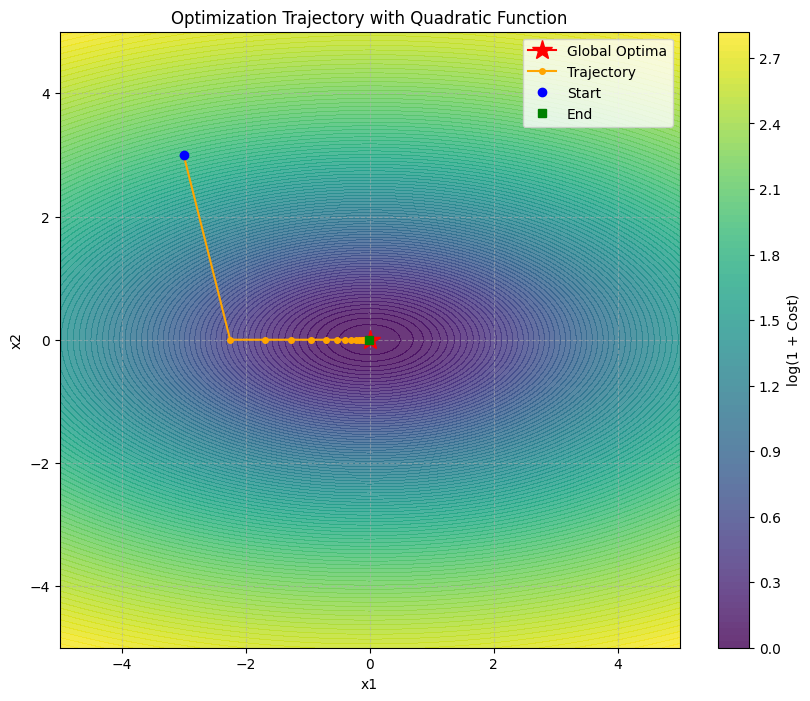

In [3]:
# Quadratic cost + GD solver
opt = UnconstrOptimizer()
opt.set_objective('quadratic')
opt.solve(x_init=[-3, 3], method='gd', max_step=100)
opt.plot_results()


**Conclusion:**

This figure illustrates the performance of GD in optimizing a quadratic objective function. Since quadratic functions are strongly convex with smooth curvature, GD ensures global convergence and follows a stable descent path. The trajectory steadily approaches the global minimum at the origin, demonstrating GD’s efficiency, especially when the Hessian has a well-conditioned structure. The log-scaled contour lines highlight the rapid cost reduction in early iterations and the slower convergence near the minimum, underscoring the importance of step size adaptation strategies like backtracking.

<br>

##### **Example 1.3: use gradient descent method to optimize Rosenbrock objective function**

Now let us consider a more challenging scenario by choosing the Rosenbrock function as the objective. Its global minimum lies at $[1.0,0.0]$, but the function is notoriously difficult to optimize due to its narrow, curved valley and steep walls, which can easily mislead simple gradient-based methods. We will attempt to optimize it using GD and observe the resulting behavior.

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`;

2\) Set the objective function to be `rosenbrock`;

3\) Call solving loop function, set the direction searching method to be `gd` and the maximal step number to be 2000~5000;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Hint: you may try the maximal step number for both lower and upper limit, which will lead to different optimization results*

4\) Plot the result and observe the optimization trajectory.

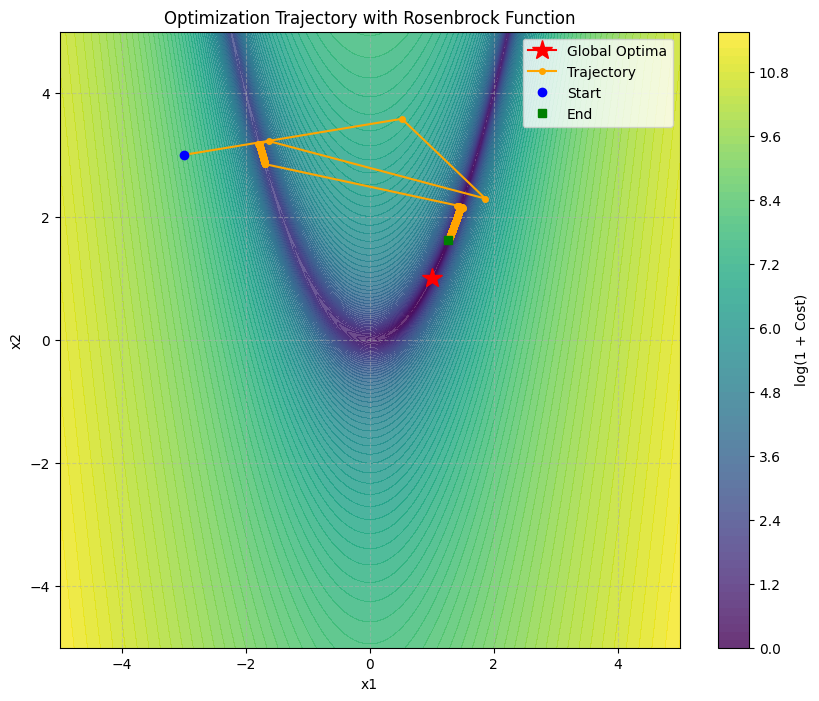

In [4]:
# Rosenbrock cost + GD solver
opt = UnconstrOptimizer()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3.0, 3.0], method='gd', max_step=2000)  # max_step: 2000 TO 5000
opt.plot_results()

**Conclusion:**

This figure shows the optimization trajectory of gradient descent applied to the Rosenbrock function over 2000 iterations. Due to the function’s narrow, curved valley and sharp gradients across directions, GD initially struggles to follow the optimal path and exhibits zigzag behavior as it gradually aligns with the valley floor. The trajectory eventually begins to converge toward the global minimum, but the progress is much slower compared to optimizing a quadratic function. **This highlights the limitations of GD in ill-conditioned landscapes, where the local curvature causes inefficient updates unless the step size is carefully controlled.** With around 5000 iterations, convergence to the minimum can be achieved, but at a significantly higher computational cost.

<br>

##### **Example 1.4: use Newton method to optimize Rosenbrock objective function**

Given the poor performance of GD on the Rosenbrock function, we now attempt to optimize it using Newton’s method. Compared to GD, Newton’s method leverages second-order curvature information, allowing it to take more informed steps and converge faster near the optimum, especially in ill-conditioned landscapes.

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`;

2\) Set the objective function to be `rosenbrock`;

3\) Call solving loop function, set the direction searching method to be `newton` and other solver parameters as follows;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Hint: now you can use a much cmaller number for the maximal step number.*

4\) Plot the result and observe the optimization trajectory.

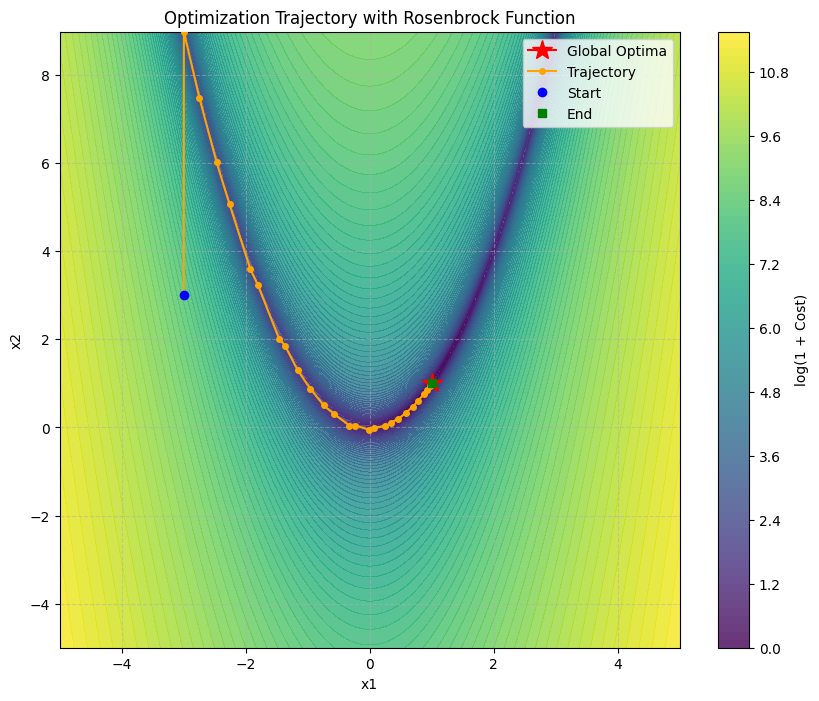

In [5]:
# Rosenbrock cost + newton solver
opt = UnconstrOptimizer()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3, 3], method='newton', max_step=100)
opt.plot_results()


**Conclusion:**

This figure shows the optimization trajectory of Newton's method applied to the Rosenbrock function. Unlike Gradient Descent, Newton’s method successfully converges to the global optimum at $[1.0,0.0]$ in fewer than 100 iterations, demonstrating significantly higher efficiency. The trajectory closely follows the curved valley, highlighting **Newton's ability to incorporate second-order curvature information for better step directions**, especially in narrow and ill-conditioned landscapes. This result underscores the strength of Newton’s method in adapting to the local geometry of complex objective functions.

However, Newton's method also has notable drawbacks when comparing with GD: **it requires computing and inverting the Hessian matrix, which can be computationally expensive and numerically unstable**, especially in high-dimensional problems. Therefore, in practical applications, the choice of direction search algorithm should be guided by the structure and properties of the specific objective function.

<br>

##### **Example 1.5: use Newton method to optimize Rastrigin objective function**

Now let us consider a more complex scenario as the testbed for Newton’s method: Rastrigin function, which is highly non-convex and characterized by a large number of regularly spaced local minima, making it particularly challenging for local optimization methods that rely on gradient and curvature information.

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`;

2\) Set the objective function to be `rastrigin`;

3\) Call solving loop function, set the direction searching method to be `newton` and other solver parameters as follows;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Hint: you may try different initializations, which will lead to different optimization results*

4\) Plot the result and observe the optimization trajectory.

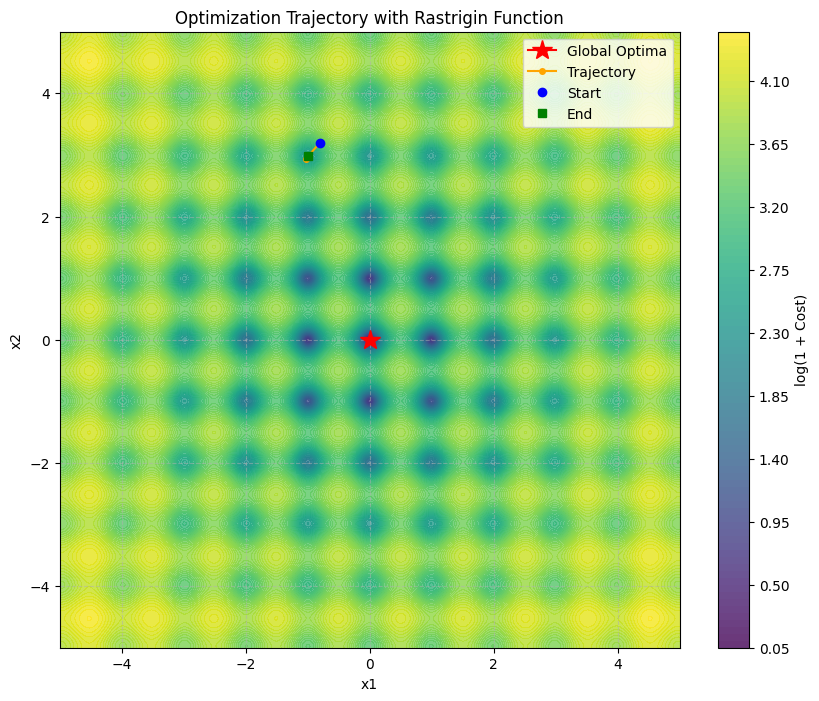

In [6]:
# Rastrigin cost + newton solver
opt = UnconstrOptimizer()
opt.set_objective('rastrigin')
opt.solve(x_init=[-0.8, 3.2], method='newton', max_step=100) # x_init: [-0.8, 3.2] OR [-0.7, 3.3] OR [-0.3, 0.3] OR [-0.2, 0.2]
opt.plot_results()

**Conclusion:**

The experimental results show that when applying Newton’s method to non-convex objective functions, the optimization trajectory is prone to getting trapped in local minima. Moreover, whether the algorithm converges to a global or local optimum largely depends on the initial starting point—Newton’s method typically converges to the nearest stationary point. **This highlights the importance of initialization: the quality of the final solution is highly sensitive to where the optimization begins.**

A simple improvement is to use multiple random initializations and select the best outcome among them. Alternatively, momentum-based methods can be introduced to help escape shallow local minima and improve global search capability.

<br>

## ❓mention: not hands-on implementation
mention libaraies + parameters

<br>

----

### **Part (b): constrained optimization**

As introduced before, a constrained optimization problem primarily follows the form:

$$
\begin{aligned}
\min_{x} \quad & f(x) \\
\text{subject to} \quad & h_i(x) = 0, \quad \forall i \in \{1, 2, \dots, N\}, \\
& g_j(x) \leq 0, \quad \forall j \in \{1, 2, \dots, M\},
\end{aligned}
$$

To solve such problems, the **Karush-Kuhn-Tucker (KKT) conditions** provide necessary conditions for optimality under regularity assumptions. The idea is to construct the **Lagrangian**:

$$
\mathcal{L}(x, \lambda, \mu) = f(x) + \sum_{i=1}^N \lambda_i h_i(x) + \sum_{j=1}^M \mu_j g_j(x),
$$

and then enforce the following **KKT conditions**:

- **Stationarity**:
   $$
   \nabla_x \mathcal{L}(x^*, \lambda^*, \mu^*) = 0
   $$

- **Primal feasibility**:
   $$
   h_i(x^*) = 0, \quad \forall i, \qquad g_j(x^*) \leq 0, \quad \forall j
   $$

- **Dual feasibility**:
   $$
   \mu_j^* \geq 0, \quad \forall j
   $$

- **Complementary slackness**:
   $$
   \mu_j^* \cdot g_j(x^*) = 0, \quad \forall j
   $$

Together, these conditions characterize candidate optimal solutions for constrained nonlinear programming problems.

Although the KKT conditions characterize optimal solutions for constrained optimization problems, they cannot be directly used to solve QP or NLP problems without additional numerical strategies. Specifically:

- **KKT conditions are not algorithms** — they provide necessary optimality conditions but do not specify how to compute the solution.

- **The KKT system itself can be complex** — even in QP problems, solving the KKT conditions leads to a linear system with complementarity constraints, which requires specialized numerical methods.

- **In SQP, KKT conditions are approximated iteratively** — each SQP iteration constructs a local QP subproblem using linearized constraints and a quadratic approximation of the cost, and solving this subproblem involves solving the KKT system numerically.

- **Modern solvers encapsulate the KKT logic internally** — tools like `qpOASES`, `OSQP`, and `Ipopt` handle all KKT-related computations, allowing users to focus on modeling rather than solver internals.

Thus, while the KKT framework underlies QP and SQP theory, practical solution requires converting the conditions into structured numerical subproblems and solving them with dedicated algorithms and solvers, which we will introduce in the following sections.

<br>

#### **Example 2.1: configurate the solver for QP problems**  


Let us first consider a simple variant of the nonlinear programming (NLP) problem: the quadratic programming (QP) problem. A QP problem is defined as an optimization problem where the objective function is quadratic and the constraints are linear. It follows the standard form:

\begin{equation}
\begin{aligned}
\min_{\bm{x}} \quad & \frac{1}{2} \bm{x}^\top \bm{H} \bm{x} + \bm{q}^\top \bm{x} \\
\text{s.t.} \quad & \bm{A}_{\text{eq}} \bm{x} = \bm{b}_{\text{eq}}\\
                  & \bm{A}_{\text{ineq}} \bm{x} \leq \bm{b}_{\text{ineq}}
\end{aligned}
\end{equation}

Here, $\bm{H} \in \mathbb{R}^{n \times n}$ is a symmetric matrix defining the curvature of the cost, and $\bm{g} \in \mathbb{R}^n$ defines the linear component of the cost. The matrices $\bm{A}_{\text{eq}} \in \mathbb{R}^{N \times n}, \bm{b}_{\text{eq}} \in \mathbb{R}^{N}, \bm{A}_{\text{ineq}}\in \mathbb{R}^{M \times n},$ and $\bm{b}_{\text{ineq}} \in \mathbb{R}^{M}$ describe the equality and inequality constraints, respectively.

Quadratic programming (QP) problems can be solved by deriving and solving the associated Karush-Kuhn-Tucker (KKT) conditions. With the advancement of symbolic and numerical computing tools, modern QP solvers such as **OSQP** and **qpOASES** have automated this process. These solvers internally construct and solve the KKT system, allowing users to simply specify the objective function, constraints, and relevant optimization parameters through a well-defined interface.

In this section, we choose **qpOASES** as the QP solver to demonstrate how to configure and use its interface for solving QP problems. It is worth noting that qpOASES is natively supported by CasADi, which allows it to be directly specified as the underlying QP solver within a CasADi-based optimization setup without requiring any separate package installation. The procedure follows the steps below:

&nbsp;&nbsp;&nbsp;&nbsp;**1\) Formulate the QP problem from external.** The standard form of a QP problem supported by CasADi is:

$$
\begin{aligned}
\min_{\bm{x}} \quad & \frac{1}{2} \bm{x}^\top \bm{H} \bm{x} + \bm{q}^\top \bm{x} \\
\text{s.t.} \quad & \bm{l}_{\text{bg}} \leq \bm{A} \bm{x} \leq \bm{u}_{\text{bg}},
\end{aligned}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $\bm{A} =
\begin{bmatrix}
\bm{A}_{\text{eq}} & \bm{0} \\
\bm{0} & \bm{A}_{\text{ineq}}
\end{bmatrix}$ defines linear constraints (inkl. equality and inequality constraints) with lower and upper bounds $\bm{l}_{\text{bg}} = \begin{bmatrix}
\bm{b}_{\text{eq}} \\
-\infty
\end{bmatrix}, \quad
\bm{u}_{\text{bg}} = \begin{bmatrix}
\bm{b}_{\text{eq}} \\
\bm{b}_{\text{ineq}}
\end{bmatrix}$.

&nbsp;&nbsp;&nbsp;&nbsp;**2\) Define the QP structure in CasADi.** To pass the QP into CasADi, you need to define a dictionary containing:

$$
\texttt{qp = \{x: }\bm{x}\texttt{, f: }f(\bm{x})\texttt{, g: }g(\bm{x})\texttt{\}},
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $f(\bm{x})=\frac{1}{2} \bm{x}^\top \bm{H} \bm{x} + \bm{q}^\top \bm{x} $ is the quadratic objective and $g(\bm{x}) = \bm{A} \bm{x}$ represents the constraint expressions.


&nbsp;&nbsp;&nbsp;&nbsp;**3\) Configure and call the solver.** Create and configure the solver using:

$$
\texttt{solver = nlpsol("solver", "qpoases", qp)},
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;and called with the necessary constraint bounds and initial guess:

$$
\texttt{sol = solver(x0, lbg, ubg)}.
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The optimal solution can then be extracted from the returned dictionary.

*Note that: for the QP solver in CasADi, please check out this material https://web.casadi.org/docs/#quadratic-programming*  




In [ ]:
class LinConstrOptimizer:
    def __init__(self):
        self.x = ca.MX.sym('x', 2)
        self.set_objective()
        self.eq_params = None
        self.ineq_params = None
        self.optimum = None

    def set_objective(self):
        self.expr = 0.5 * (self.x[0]**2 / 4 + self.x[1]**2)
        self.f = ca.Function('f', [self.x], [self.expr])
        self.global_minima = np.array([0.0, 0.0])

    def set_constraints(self, eq_params=None, ineq_params=None):
        self.eq_params = eq_params
        self.ineq_params = ineq_params

    def solve(self, x_init=[0.0, 0.0]):

        A_list = []
        lba = []
        uba = []

        if self.eq_params:
            a, b, c = self.eq_params
            A_list.append(np.array([[a, b]]))
            lba.append(-c)
            uba.append(-c)

        if self.ineq_params:
            a, b, c = self.ineq_params
            A_list.append(np.array([[a, b]]))
            lba.append(-np.inf)
            uba.append(-c)

        A_total = np.vstack(A_list) if A_list else np.zeros((0, 2))
        lba = np.array(lba)
        uba = np.array(uba)

        qp = {
            'x': self.x,
            'f': self.expr,
            'g': ca.mtimes(ca.DM(A_total), self.x)
        }
        
        solver = ca.qpsol('solver', 'qpoases', qp)

        sol = solver(x0=x_init, lbg=lba, ubg=uba)

        self.optimum = sol['x'].full().flatten()
        
        return self.optimum.tolist()

    def plot_results(self):
        x_max = 2.5
        x_min = -2.5
        y_max = 2.5
        y_min = -2.5

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')

        if self.eq_params:
            a, b, c = self.eq_params
            if b != 0:
                x_eq = np.linspace(x_min, x_max, 400)
                y_eq = (-a * x_eq - c) / b
                ax.plot(x_eq, y_eq, 'k--', linewidth=2, label='Equality Constraint')
            else:
                x_eq = -c / a
                ax.axvline(x_eq, color='k', linestyle='--', linewidth=2, label='Equality Constraint')

        if self.ineq_params:
            a, b, c = self.ineq_params
            if b != 0:
                x_ineq = np.linspace(x_min, x_max, 400)
                y_ineq = (-a * x_ineq - c) / b
                ax.plot(x_ineq, y_ineq, 'b-', linewidth=2, label='Inequality Constraint')
                ax.fill_between(x_ineq, y_ineq, y_max, color='blue', alpha=0.1)
            else:
                x_ineq = -c / a
                ax.axvline(x_ineq, color='b', linestyle='-', linewidth=2, label='Inequality Constraint')
                if a > 0:
                    ax.axvspan(x_min, x_ineq, color='blue', alpha=0.1)
                else:
                    ax.axvspan(x_ineq, x_max, color='blue', alpha=0.1)

        if self.optimum is not None:
            ax.plot(self.optimum[0], self.optimum[1], 'gs', markersize=10, label='Optimal Point', zorder=11)

        ax.plot(self.global_minima[0], self.global_minima[1], '*', color='red', markersize=15, label='Global Min')
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("Constrained Optimization Result (QPOASES)")
        ax.grid(True)
        ax.legend()
        plt.show()



<br>

##### **Example 2.2: use QP solver to optimize quadratic objective function with linear constraint**

❓steps + formulation of constraints


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

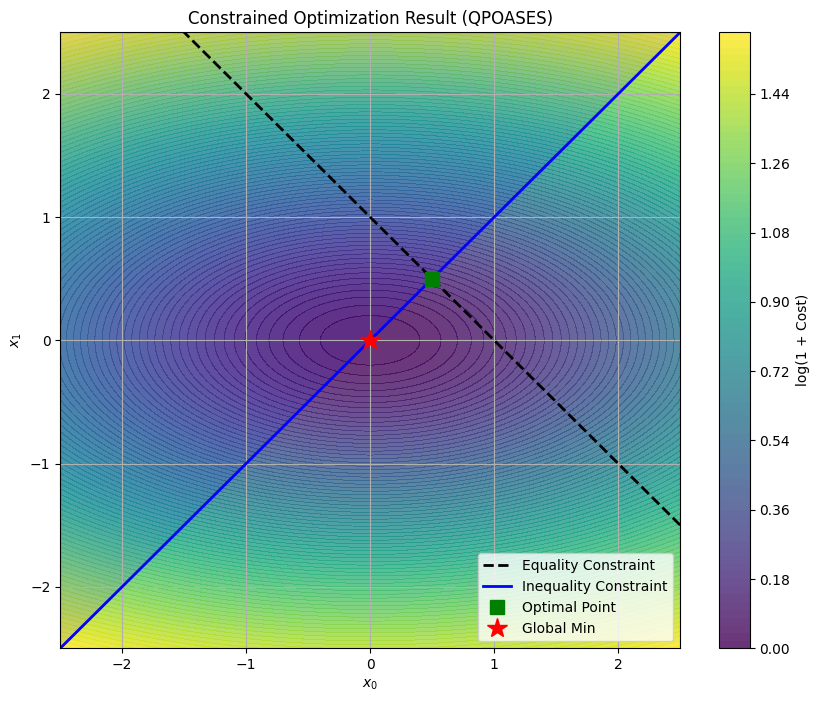

In [8]:
# qpOASES for QP
opt = LinConstrOptimizer()
opt.set_constraints(eq_params=(1, 1, -1), ineq_params=(1, -1, 0))
opt.solve(x_init=[0.0, 1.0])
opt.plot_results()




#### **Example 3.1: configurate the solver for NLP problems**  



❓introduce: SQP -> SQP solver


The configuration of a SQP solver is similar to the QP solver, which follows the steps:

&nbsp;&nbsp;&nbsp;&nbsp;**1) Formulate the NLP problem.** The standard form of a generic nonlinear programming (NLP) problem is:

$$
\begin{aligned}
\min_{\bm{x}} \quad & f(\bm{x}) \\
\text{s.t.} \quad & \bm{h}(\bm{x}) = \bm{0}, \\
                  & \bm{g}(\bm{x}) \leq \bm{0},
\end{aligned}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $ f(\bm{x}) $ is a nonlinear cost function, $ \bm{h}(\bm{x}) $ defines equality constraints, and $ \bm{g}(\bm{x}) $ defines inequality constraints.

&nbsp;&nbsp;&nbsp;&nbsp;**2) Define the NLP structure in CasADi.** To pass the NLP into CasADi, you need to define a dictionary:

$$
\texttt{nlp = \{x: } \bm{x} \texttt{, f: } f(\bm{x}) \texttt{, g: } \bm{c}(\bm{x}) \texttt{\}},
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $ \bm{x} \in \mathbb{R}^n $ is the optimization variable, $ f(\bm{x}) $ is the cost function, and $ \bm{c}(\bm{x}) $ combines all constraints:

$$
\bm{c}(\bm{x}) =
\begin{bmatrix}
\bm{h}(\bm{x}) \\
\bm{g}(\bm{x})
\end{bmatrix}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The corresponding lower and upper bounds are:

$$
\bm{l}_c =
\begin{bmatrix}
\bm{0} \\
-\infty
\end{bmatrix}, \quad
\bm{u}_c =
\begin{bmatrix}
\bm{0} \\
\bm{0}
\end{bmatrix}
$$


&nbsp;&nbsp;&nbsp;&nbsp;**3) Configure and call the solver.** Create the SQP solver by specifying the backend as `"sqpmethod"`:

$$
\texttt{solver = nlpsol("solver", "sqpmethod", nlp)}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Then solve the problem with an initial guess and the constraint bounds:

$$
\texttt{sol = solver(x0, lbg = } \bm{l}_c \texttt{, ubg = } \bm{u}_c \texttt{)}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The optimal solution can be extracted from `sol['x']`.

*Note that: for the NLP solver in CasADi, please check out this material https://web.casadi.org/docs/#nonlinear-programming.*  


In [9]:
class SQPOptimizer:
    def __init__(self, objective_func, eq_func=None, ineq_func=None, global_minima=None):
        self.objective_func = objective_func
        self.eq_func = eq_func
        self.ineq_func = ineq_func
        self.global_minima = np.array(global_minima) if global_minima is not None else None

        self.x_dim = self.objective_func.size_in(0)[0]
        self.x_start = None
        self.x_end = None
        self._setup_nlp()

    def _setup_nlp(self):
        x = ca.MX.sym('x', self.x_dim)
        cost = self.objective_func(x)

        constraints = []
        lbg = []
        ubg = []

        if self.eq_func is not None:
            eq_expr = self.eq_func(x)
            constraints.append(eq_expr)
            lbg.append(np.zeros(eq_expr.shape[0]))
            ubg.append(np.zeros(eq_expr.shape[0]))

        if self.ineq_func is not None:
            ineq_expr = self.ineq_func(x)
            constraints.append(ineq_expr)
            lbg.append(-np.inf * np.ones(ineq_expr.shape[0]))
            ubg.append(np.zeros(ineq_expr.shape[0]))

        if constraints:
            g = ca.vertcat(*constraints)
            self.lbg = np.concatenate(lbg)
            self.ubg = np.concatenate(ubg)
        else:
            g = ca.MX()
            self.lbg = np.array([])
            self.ubg = np.array([])

        self.x_sym = x
        self.nlp = {'x': x, 'f': cost, 'g': g}
        self.solver = ca.nlpsol('solver', 'sqpmethod', self.nlp, {'qpsol': 'qrqp', 'print_time': 0})

    def solve(self, x_init):
        x_init = np.array(x_init).flatten()
        self.x_start = x_init.copy()

        sol = self.solver(x0=x_init, lbg=self.lbg, ubg=self.ubg)
        self.x_end = np.array(sol['x'].full()).flatten()

        return self.x_end
    
    def plot_results(self):
        x_max, x_min, y_max, y_min = 2.5, -2.5, 2.5, -2.5
        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.objective_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')

        # Inequality constraint
        if self.ineq_func is not None:
            G_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    G_vals[i, j] = self.ineq_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, G_vals, levels=[0], colors='b', linewidths=2)
            ax.contourf(X, Y, G_vals, levels=[-np.inf, 0], colors='blue', alpha=0.1)

        # Equality constraint
        if self.eq_func is not None:
            H_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    H_vals[i, j] = self.eq_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, H_vals, levels=[0], colors='k', linewidths=2, linestyles='--')

        # Plot optimal point
        if self.x_end is not None:
            ax.plot(self.x_end[0], self.x_end[1], 'gs', markersize=10, label='Optimal Point', zorder=11)

        # Plot known global minimum
        if self.global_minima is not None:
            ax.plot(self.global_minima[0], self.global_minima[1], '*', color='red', markersize=15, label='Global Min')

        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("SQP (sqpmethod) Optimization Result")
        ax.grid(True)
        ax.legend()
        plt.show()




<br>

##### **Example 3.2: use SQP solver to optimize quadratic objective function with nonlinear constraint**

❓steps + formulation of constraints

-------------------------------------------
This is casadi::QRQP
Number of variables:                               2
Number of constraints:                             1
Number of nonzeros in H:                           2
Number of nonzeros in A:                           2
Number of nonzeros in KKT:                         7
Number of nonzeros in QR(V):                       5
Number of nonzeros in QR(R):                       6
-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                               2
Number of constraints:                             1
Number of nonzeros in constraint Jacobian:         2
Number of nonzeros in Lagrangian Hessian:          2

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls    info
   0   1.460000e+00  0.00e+00  1.60e+00  0.00e+00       -  0  - 
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         0    -1   

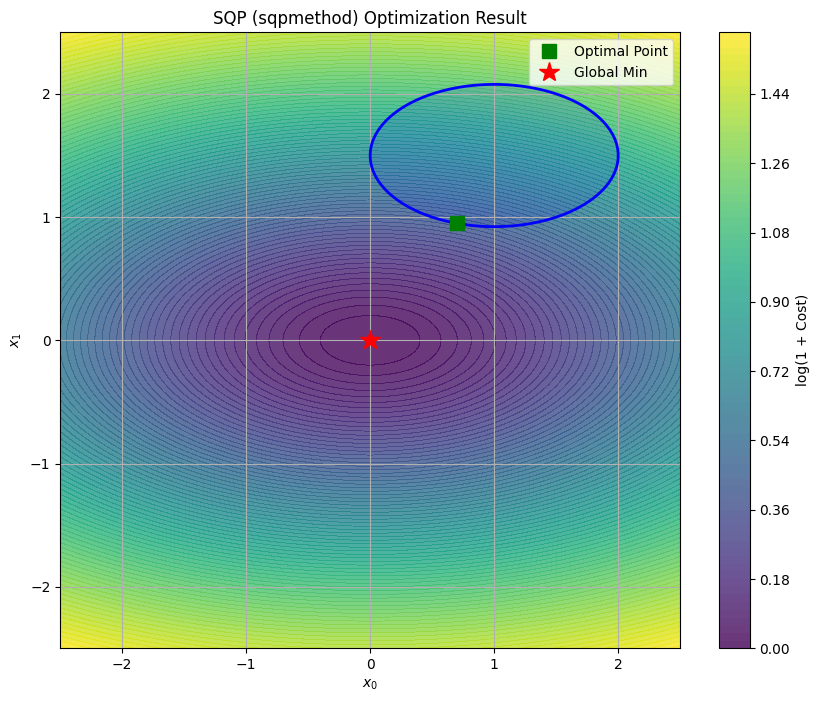

In [10]:
x = ca.MX.sym('x', 2)
f = ca.Function("f", [x], [0.5 * (x[0]**2 / 4 + x[1]**2)])

g = ca.Function("g", [x], [(x[0] - 1)**2 + (x[1] - 1.5)**2 * 3 - 1])  # g(x) <= 0
h = None  

sqp_solver = SQPOptimizer(
    objective_func=f,
    eq_func=h,
    ineq_func=g,
    global_minima=[0, 0]
)

sol = sqp_solver.solve([1.2, 1.6])
sqp_solver.plot_results()
